## PSF photometry on PAL5 using fixed centroids

This notebook uses the fixed centroids for completing PSF photometry on the Palomar 5 globular cluster in order to compare accuracy with the previous PSF method used in the preceeding notebooks. As typical so far, no uncertainties are being calculated just yet but will be added in later versions of this document.

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from astropy.io import fits # used for FITS file management
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import BasicPSFPhotometry
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground

PAL5_data/PAL5/PAL5_3p6um.fits
FLUXCONV = 0.1257
EXPTIME = 585.054


216


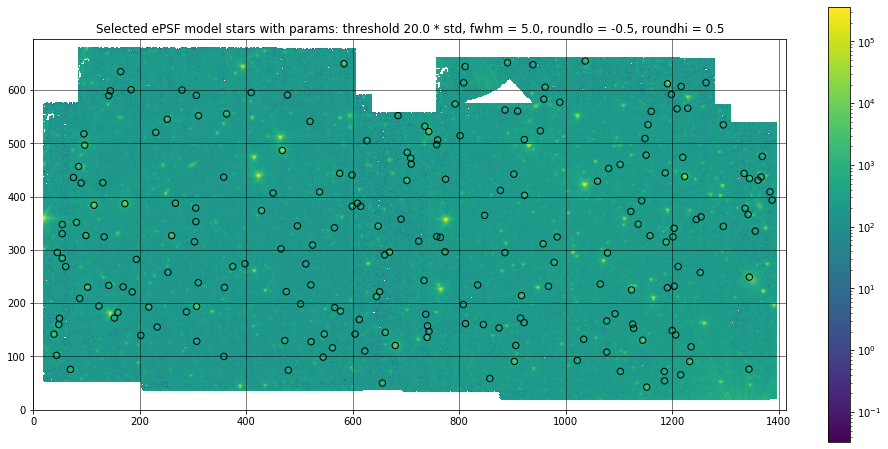

 id      xcenter       ...      aper_bkg       aper_sum_bkgsub  
           pix         ...                                      
--- ------------------ ... ------------------ ------------------
  1 1152.0517082774918 ... 33771.679623118565 121095.16155384525
  2  655.6895914558028 ... 23662.815739456637  52080.14393770306
  3  1185.577413868922 ... 29302.509049081094  9420.372998165254
  4  857.5039721371419 ... 25739.616817245245 15957.198084399788
  5    1216.0011727722 ...  33993.41156056987  8181.282731091662
  6  1102.806752375499 ... 27400.320620882314  19952.31329533718
  7 1185.1353172656004 ... 30119.865784718157  20490.70276391332
  8 478.94414076846977 ... 20125.095844728592 20772.822094983112
  9  69.68612460427812 ...  22128.01935316084  47344.92673786936
 10 1344.1825943898746 ...  37980.83815263823  34228.71576504386
...                ... ...                ...                ...
207 1216.9219910450354 ... 21928.045399204897 10274.875873925292
208 1191.0598647058598 ..

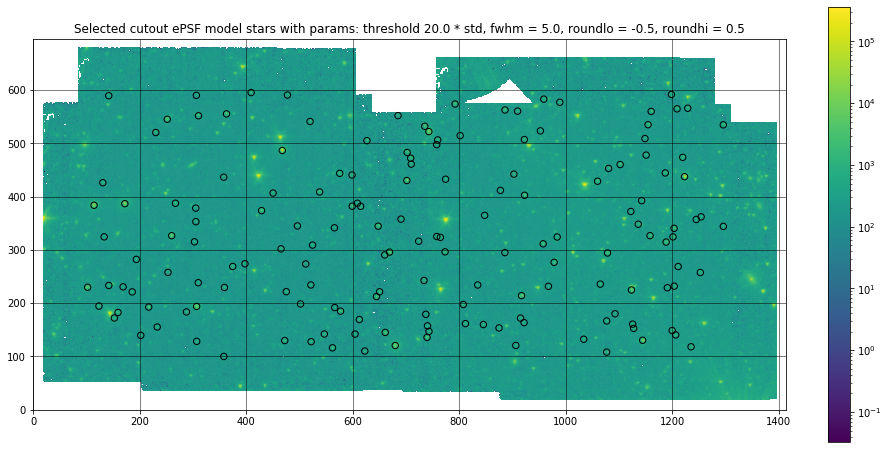

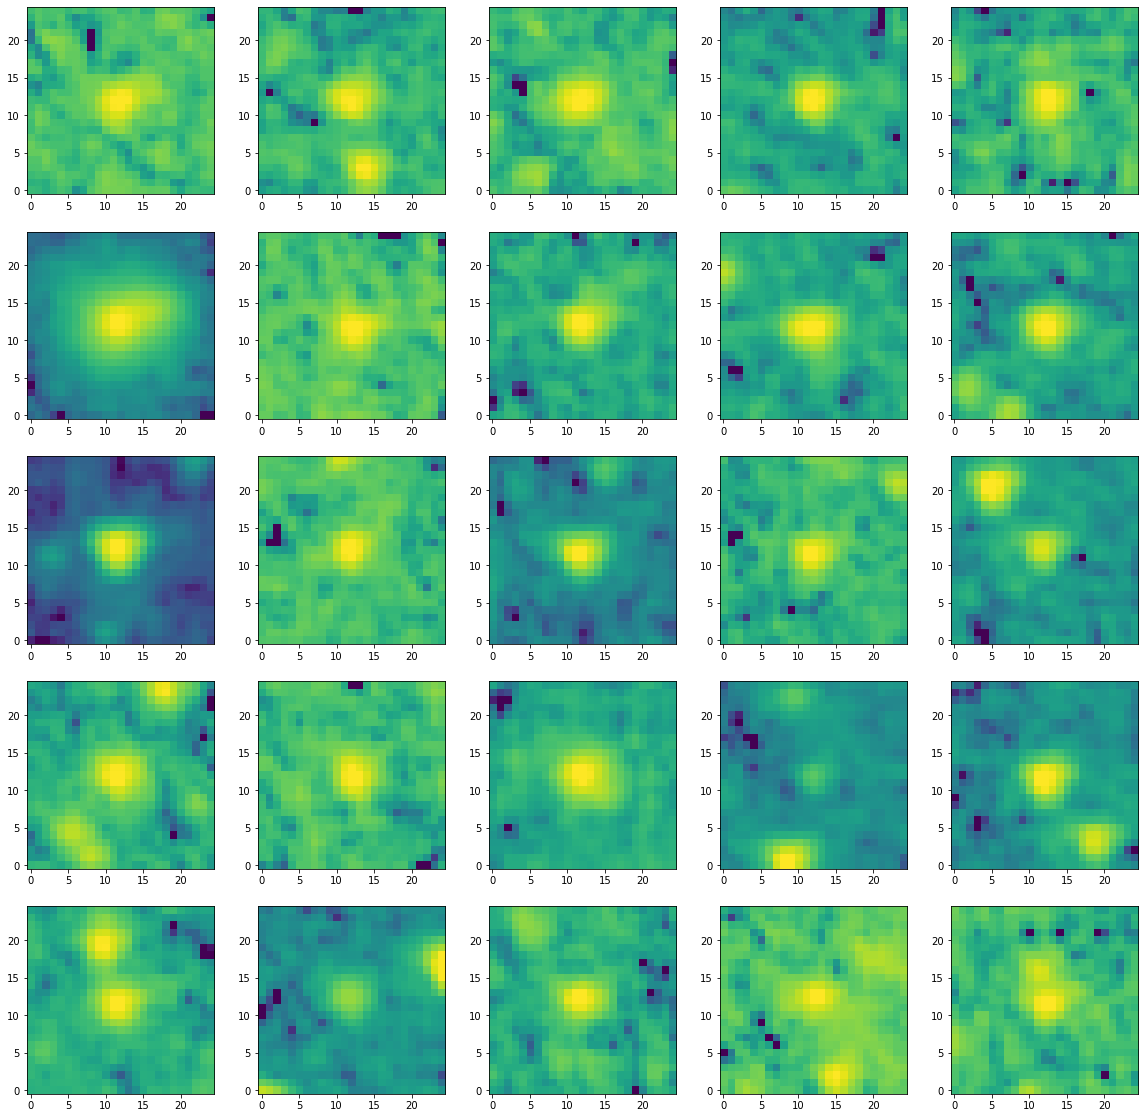

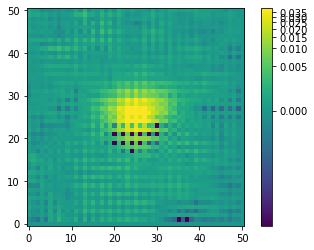

HERE
 id      xcentroid      ...        flux                 mag         
---- ------------------ ... ------------------ ---------------------
   1  964.1229817914556 ... 1.1934626992859854   -0.1920221250778885
   2 1010.8564782649522 ... 1.1453900938111643  -0.14738355672642534
   3 1081.5340468794009 ... 1.7377978734035708   -0.5999981535693775
   4 1111.2549338778633 ... 1.9704489889847858   -0.7364129908114889
   5 1145.0053185881977 ... 1.9444543023019405   -0.7219943525203316
   6 1136.6559276897092 ... 1.0124261687262792 -0.013408405188631373
   7  1264.246256589776 ... 1.2371447486423632  -0.23105129001643995
   8 1291.2929189184636 ... 2.7181857032157932   -1.0856978097318768
   9 1357.2969743700087 ...  1.851816323563567   -0.6689947700943627
  10 1184.4279045015637 ... 1.8703016881549182   -0.6797791646476469
 ...                ... ...                ...                   ...
2260  460.6923837633458 ...  1.108098776440615  -0.11144618832549406
2261 481.78568704749443 ... 1

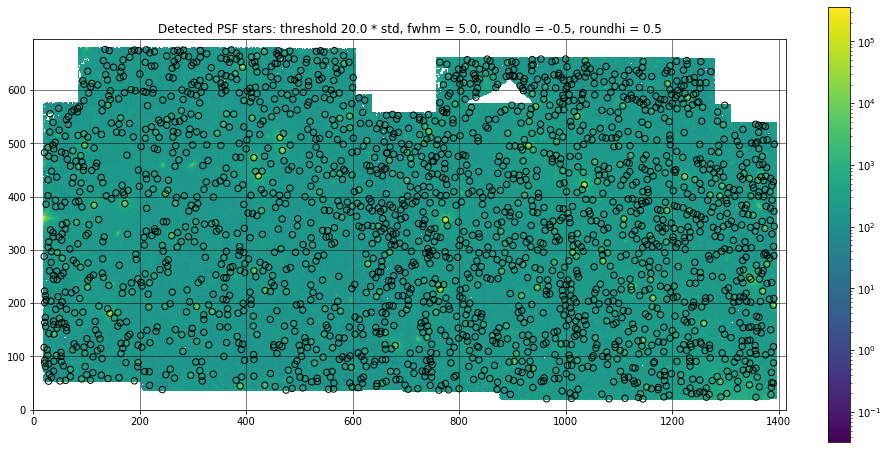

Number of stars detected = 2270


2270


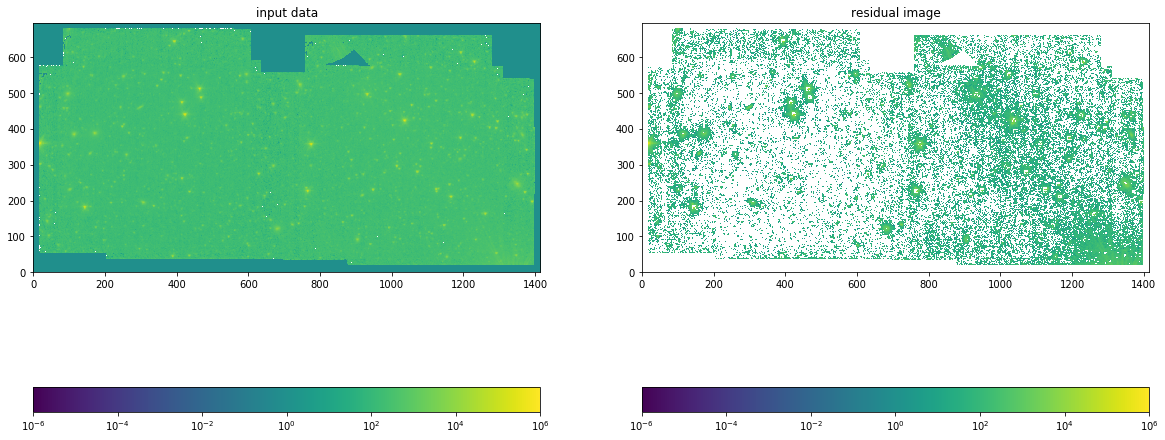

 id     x_0       y_0      flux_0   apparent_mag
---- --------- --------- ---------- ------------
   1 964.12298 20.311686 -4219.0431          nan
   2 1010.8565 21.009269 -3065.7271          nan
  11 1017.3142 26.634326  7157.1347    18.204922
  17 1008.3452 31.020315  657.74542    20.796626
  24 993.21845 35.082207  8809.7009    17.979367
  31 1023.2538 38.331594  1239.1097    20.108996
   3  1081.534 20.460469 -817.42694          nan
  14 1068.0214 29.086694  2731.2489    19.250867
   4 1111.2549 21.321663  1518.0979    19.888521
   5 1145.0053 20.068949  8975.8352    17.959083
 ...       ...       ...        ...          ...
2254 275.94471 672.10565 -5274.7435          nan
2258 263.85996 673.55191 -2557.6946          nan
2259 313.68421 674.54208  -5233.023          nan
2266 281.87187 675.39181 -1860.0493          nan
2270 271.01985 674.92666 -15951.037          nan
2127 199.93597 630.42654 -2149.9519          nan
2146 101.98092 635.76952  1174.0804    20.167526
2190 776.77231 648.6

In [20]:
## DEFINING BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/PAL5/'
channel = '3p6um'

file = base_dir+'PAL5_'+channel+'.fits'
print(file)

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    counts = exptime / fluxconv
    image_data = fits.getdata(file, ext = 0)
    data = image_data * counts
    print('FLUXCONV = {}\nEXPTIME = {}'.format(fluxconv, exptime))
#___________________________________#
## BUILDING ePSF MODEL FOR PHOTOMETRY
## SOURCE DETECTION FOR ePSF MODEL ##

# PARAMETERS #
sigma_val = 4.
fwhm = 5.
threshold = 100.
roundlo = -0.5
roundhi = 0.5
sharphi = 0.8

mean, median, std = sigma_clipped_stats(data, sigma = sigma_val)

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = threshold * std, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
epsf_sources = starfind_init(data)
print(len(epsf_sources))

# plot detected stars for ePSF model to verify good stars
positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
apertures = CircularAperture(positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

## APERTURE PHOTOMETRY ##

positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
circular_apertures = CircularAperture(positions, r = 6.)
annuli_apertures = CircularAnnulus(positions, r_in = 6., r_out = 14.)
apertures = [circular_apertures, annuli_apertures]

# initial aperture photometry table
phot_init = aperture_photometry(data, apertures)

# background subtraction using sigma-clipped median and annuli
annulus_masks = annuli_apertures.to_mask(method = 'center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0] # extract 1D array of data values
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
# now append bkg_median, aperture background and aperture sum background values to photometry data
phot_init['annulus_median'] = bkg_median
phot_init['aper_bkg'] = bkg_median * circular_apertures.area
phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
print(phot_init)

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

# table of star positions
star_tbl = Table()
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
print(len(star_tbl))

# visualise stars to verify
cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
cutout_apers = CircularAperture(cutout_pos, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
cutout_apers.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected cutout ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

## EXTRACT STARS ##

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = 5.)
temp_data = data - median_val

nddata = NDData(data = temp_data)
stars = extract_stars(nddata, star_tbl, size = 25)

# visualise 36 extracted stars
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent = 99.)
    ax[i].imshow(stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
plt.show()
plt.close()
    
## BUILD ePSF ##

epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
epsf, fitter = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent = 99.)
plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
plt.colorbar()
plt.show()

## PSF PHOTOMETRY ##

## SOURCE DETECTION ON ORIGINAL IMAGE ##
# PARAMETERS #

sigma_psf = 6.
fwhm = 5.
roundlo = -0.5
roundhi = 0.5

psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_psf * std, roundlo = roundlo, roundhi = roundhi)
psf_sources = psf_daofind(data)
print('HERE')
print(psf_sources)

psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
psf_apertures = CircularAperture(psf_positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
psf_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Detected PSF stars: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

print('Number of stars detected = {}'.format(len(psf_sources)))

## GROUP ##

psf_sources['xcentroid'].name = 'x_0'
psf_sources['ycentroid'].name = 'y_0'

daogroup = DAOGroup(crit_separation = sigma_psf * fwhm)
bkg_estimator = MMMBackground()
fitter = LevMarLSQFitter()

data_psf = np.nan_to_num(data, nan = 1**-7)

## FIXED CENTROIDS ##

epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])

## PHOTOMETRY ##

PSF_photometry = BasicPSFPhotometry(#finder = psf_daofind,
                                    group_maker = daogroup,
                                    bkg_estimator = bkg_estimator,
                                    psf_model = epsf,
                                    fitter = fitter,
                                    #niters = 2,
                                    aperture_radius = 6.,
                                    fitshape = (11, 11))

result_phot = PSF_photometry(image = data_psf, init_guesses = pos)
residual_image = PSF_photometry.get_residual_image()

hdu = fits.PrimaryHDU(residual_image)
hdul = fits.HDUList([hdu])
hdul.writeto('residual_image_07_fixed_centroids.fits')
print(len(result_phot))

# visualise data
plt.subplot(1, 2, 1)
plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('input data')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('residual image')
plt.colorbar(orientation = 'horizontal')
plt.gcf().set_size_inches(20, 14)
plt.show()

## APPARENT MAGNITUDES ##
aper_corr = 1.125      # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
zeropoint_flux = 280.9 # see Reach et al. 2005
zmag = 18.8            # from IRAC handbook §4.8

phot = result_phot                  # redefine photometry table for ease
phot['bkgsub_flux'] = float('NaN')  # populate new column to convert into flux
phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

for i in range(0, len(phot)):
    phot['bkgsub_flux'][i] = phot['flux_0'][i] * fluxconv / exptime
    for i in range(0, len(phot)):
        if phot['bkgsub_flux'][i] >= 0:
            phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['bkgsub_flux'][i] * aper_corr)

# export into csv file
phot['id', 'x_0', 'y_0', 'apparent_mag'].write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\psfphot01_test.txt', format = 'csv', overwrite = True)
           
# format columns
for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot['id', 'x_0', 'y_0', 'flux_0', 'apparent_mag'])